# Stations network (summer 2018, weekday)


In [1]:
%matplotlib inline 
#%matplotlib inline notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplleaflet
import pandas as pd
import numpy as np
import json
import math
from matplotlib import cm

import networkx as nx
import matplotlib.pyplot as plt

#import os

#os.environ['PROJ_LIB'] = r'C:\Users\pgsze\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

from mpl_toolkits.basemap import Basemap

# Import, and set to log to the console.  (See the console which is running
# Jupyter notebook for logging about HTTP requests.)
#import tilemapbase
#tilemapbase.start_logging()

In [2]:
###
subs_df = pd.read_pickle('../../data/pickledDFs/subs_df-NYC_Summer_2018.pkl')
stations_info_df = pd.read_pickle('../../data/pickledDFs/stations_info_df-NYC_Summer_2018.pkl')
subs_trips_df = pd.read_pickle('../../data/pickledDFs/subs_trips_df-NYC_Summer_2018.pkl')
###

In [3]:
subs_df[subs_df['start station latitude']>41]

Empty DataFrame
Columns: [tripduration, starttime, stoptime, start station id, start station name, start station latitude, start station longitude, end station id, end station name, end station latitude, end station longitude, bikeid, usertype, birth year, gender]
Index: []

In [4]:
#Number of weekend days and weekday days for Jan - March 2018
#num_WE = 25
#num_WD = 31+28+31-num_WE #Note I'm not subtracting holidays here, maybe later...

In [5]:
weekday_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] != 'Weekend'].copy()
weekend_subs_trips_df = subs_trips_df[subs_trips_df['Trip_Type'] == 'Weekend'].copy()

In [6]:
#Need to filter out stations in stations_info_df that do not appear in weekday_subs_trips
station_drops = []
WD_unique = np.unique(np.concatenate((weekday_subs_trips_df['start station id'].unique(),weekday_subs_trips_df['end station id'].unique())))

for ind in stations_info_df.index:
    if not (ind in WD_unique):
        station_drops.append(ind)
        
print(station_drops)

stations_info_df.drop(station_drops,inplace=True)
len(stations_info_df) == len(WD_unique)

[3276, 3184, 3202, 3195, 3185]


True

In [7]:
weekday_subs_trips_df.head()

tripduration               starttime                stoptime  \
0           569 2018-06-01 01:57:20.514 2018-06-01 02:06:50.088   
1           480 2018-06-01 02:02:42.398 2018-06-01 02:10:43.354   
2           692 2018-06-01 02:04:23.624 2018-06-01 02:15:55.747   
3           664 2018-06-01 03:00:55.461 2018-06-01 03:11:59.906   
4           818 2018-06-01 06:04:54.427 2018-06-01 06:18:32.617   

   start station id  end station id  bikeid    usertype  birth year  gender  \
0                72             173   21481  Subscriber        1999       1   
1                72             477   19123  Subscriber        1988       1   
2                72             457   26983  Subscriber        1986       1   
3                72             379   26742  Subscriber        1973       1   
4                72             459   26386  Subscriber        1984       1   

   start_day  stop_day  pickup_hour  dropoff_hour  age   Trip_Type  \
0          4         4            1             2   19  Late Night   
1          4         4            2             2   30  Late Night   
2          4         4            2             2   32  Late Night   
3          4         4            3             3   45  Late Night   
4          4         4            6             6   34    Commuter   

  start_end_station  
0         (72, 173)  
1         (72, 477)  
2         (72, 457)  
3         (72, 379)  
4         (72, 459)

In [22]:
edge_list_ser = weekday_subs_trips_df.groupby('start_end_station').count()['bikeid']
edge_list_ser = edge_list_ser[edge_list_ser > 100]
len(edge_list_ser)

9641

In [23]:
G = nx.Graph()

In [24]:
w_edge_list = [(i[0],i[1],edge_list_ser[i]) for i in edge_list_ser.index]

In [25]:
G.add_weighted_edges_from(w_edge_list,weight='num_trips')

In [26]:
num_out_df = weekday_subs_trips_df.groupby('start station id').count()['bikeid']
num_in_df = weekday_subs_trips_df.groupby('end station id').count()['bikeid']

tot_df = num_in_df+num_out_df

tot_df.head()

72     17071.0
79     12804.0
82      4614.0
83      7496.0
119     1386.0
Name: bikeid, dtype: float64

In [27]:
btwn_centrality_ser = pd.Series(nx.betweenness_centrality(G,normalized=True, endpoints=False))
close_centrality_ser = pd.Series(nx.closeness_centrality(G,wf_improved=True))

In [28]:
import tilemapbase
tilemapbase.start_logging()

In [29]:
NYC_center = (-74.006,40.713)
NYC_center_moves = []

for num in range(5):
    NYC_center_moves.append(tuple([NYC_center[0]+num*.001,NYC_center[1]+num*.001]))

extent = tilemapbase.Extent.from_lonlat(-74.03,-73.91, 40.65, 40.81)

#extent = extent.to_aspect(1)
extent

Extent((0.29436111111111113,0.3756243319633231)->(0.2946944444444445,0.37621083107798253) projected as normal)

In [30]:
t = tilemapbase.tiles.Carto_Light

In [31]:
for node in G.nodes():
    G.nodes[node]['Location']= (stations_info_df.loc[node]['lon'],stations_info_df.loc[node]['lat'])
    G.nodes[node]['TMB_loc']= tilemapbase.project(nx.get_node_attributes(G,'Location')[node][0],nx.get_node_attributes(G,'Location')[node][1])
    G.nodes[node]['usage']= tot_df.loc[node]

## Degree as node color

the degree node v is the number of edges connected to it

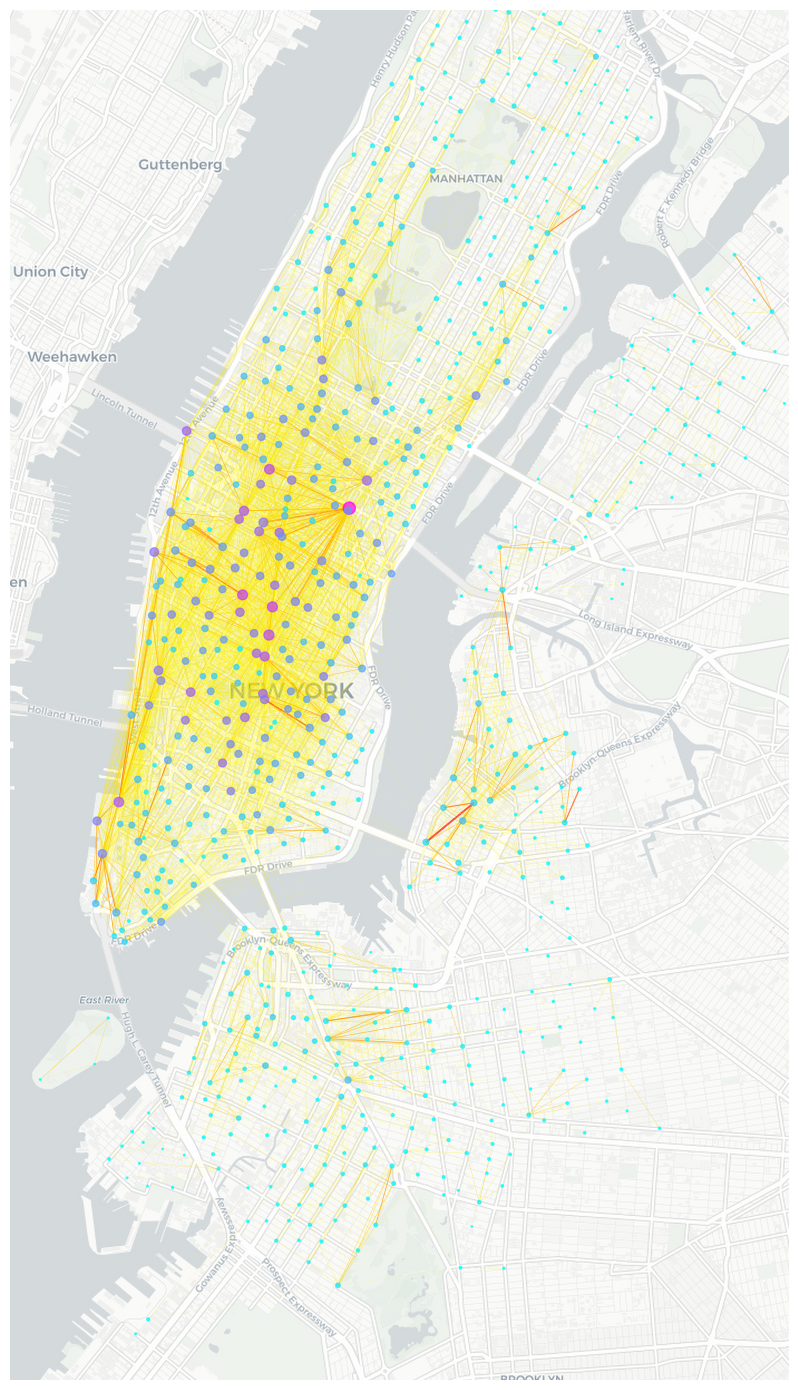

In [32]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


node_color = [G.degree(v) for v in G]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Betweenness centrality as node color 
betweenness centrality of node v is the sum over all pairs of nodes s, t in the graph of the percentage of shortest paths between s, t that contain node v

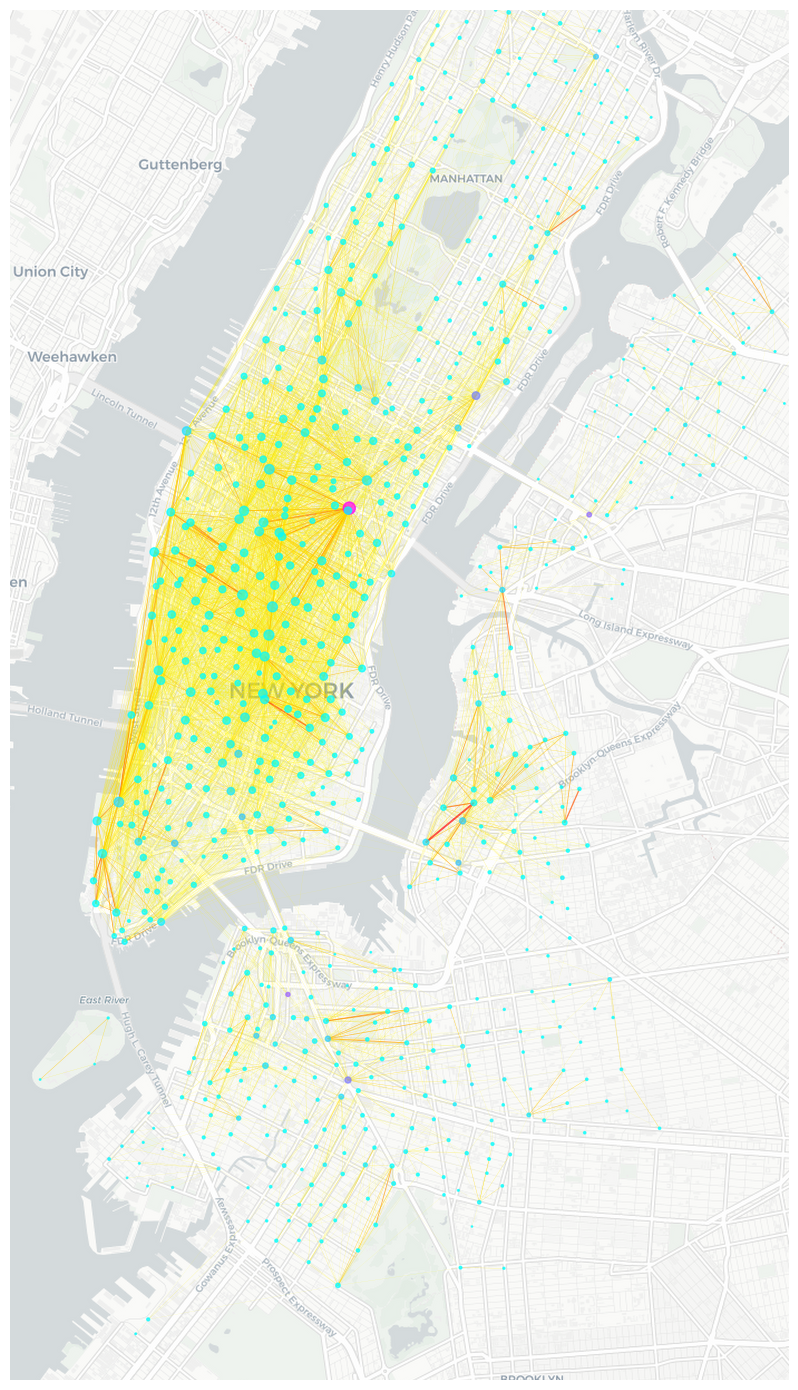

In [40]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
btwn_max = btwn_centrality_ser.max()
node_color = [btwn_centrality_ser.loc[node]/btwn_max for node in G.nodes()]
#node_color = [close_centrality_ser.loc[node]/close_centrality_ser.max() for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 vmin=sorted(node_color)[0],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();

## Closeness centrality as node color

closeness centrality of a node v is defined as the inverse of the sum of the shorest path distances between node v and every other connected node in the graph

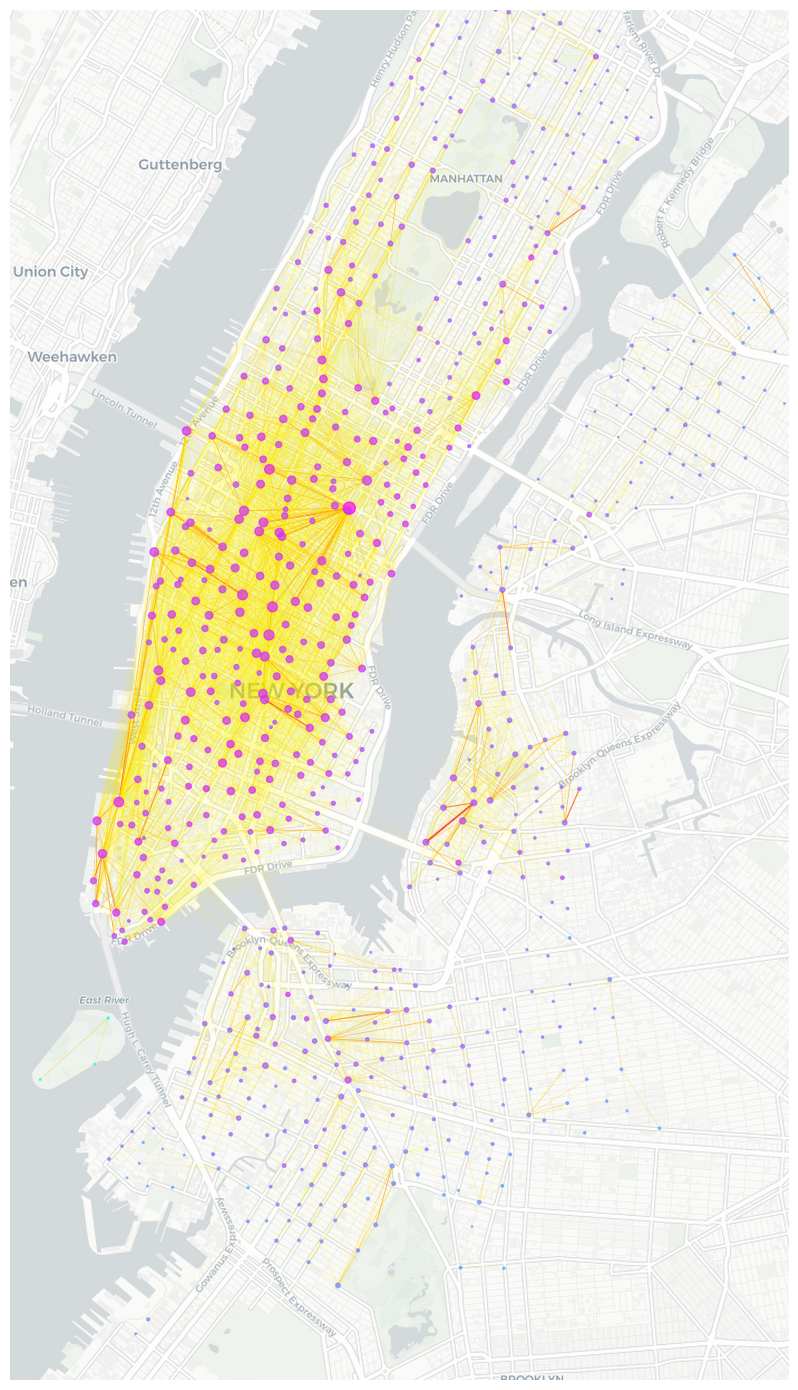

In [41]:
#node color = degree
fig, ax = plt.subplots(figsize=(14,14), dpi=100)
    
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)


#node_color = [G.degree(v) for v in G]
#node_color = [btwn_centrality_ser.loc[node]/btwn_centrality_ser.max() for node in G.nodes()]
close_max=close_centrality_ser.max()
node_color = [close_centrality_ser.loc[node]/close_max for node in G.nodes()]
node_size = [0.001*nx.get_node_attributes(G, 'usage')[v] for v in G]
#pos = nx.get_node_attributes(G,'Location')
pos=nx.get_node_attributes(G,'TMB_loc')
edge_width = [0.0005*G[u][v]['num_trips'] for u,v in G.edges()]

nx.draw_networkx(G, pos, node_size=node_size, 
                 node_color=node_color, alpha=.7, with_labels=False, 
                 width=edge_width, #edge_color='.4', 
                 cmap=plt.cm.cool,
                 #there is one node with CC=zero, which I am dropping in v_range
                 vmin=sorted(node_color)[1],vmax = sorted(node_color)[-1],
                 edge_color = list(nx.get_edge_attributes(G,'num_trips').values()),
                 edge_cmap = plt.cm.autumn_r,
                 edge_vmin = sorted(nx.get_edge_attributes(G,'num_trips').values())[0], edge_vmax = sorted(nx.get_edge_attributes(G,'num_trips').values())[-1])

plt.axis('off')
plt.tight_layout();